In [1]:
import os

import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.datasets import load_iris

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


from skl2onnx.common.data_types import FloatTensorType
from skl2onnx import convert_sklearn

import onnxruntime as rt

from onnx.tools.net_drawer import GetPydotGraph, GetOpNodeProducer

In [2]:
iris_data = load_iris()

X = pd.DataFrame(data=iris_data.data,
                 columns=['_'.join(feature_name.split()[:2]) for feature_name in iris_data.feature_names])
y = pd.DataFrame(data=iris_data.target,
                 columns=['species'])

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3)

In [3]:
iris_train = pd.concat([X_train,
                        y_train],
                       axis=1)
iris_train.head()

,sepal_length,sepal_width,petal_length,petal_width,species
73,6.1,2.8,4.7,1.2,1
131,7.9,3.8,6.4,2.0,2
59,5.2,2.7,3.9,1.4,1
97,6.2,2.9,4.3,1.3,1
58,6.6,2.9,4.6,1.3,1


In [4]:
iris_test = pd.concat([X_test,
                       y_test],
                      axis=1)
iris_test.head()

,sepal_length,sepal_width,petal_length,petal_width,species
136,6.3,3.4,5.6,2.4,2
49,5.0,3.3,1.4,0.2,0
84,5.4,3.0,4.5,1.5,1
14,5.8,4.0,1.2,0.2,0
66,5.6,3.0,4.5,1.5,1


In [5]:
sepal_features = [0,1]
petal_features = [2,3]

sepal_transformer = Pipeline(steps=[
    ('imputer',
     SimpleImputer(strategy='mean')),
    ('scaler',
     StandardScaler())
])

petal_transformer = Pipeline(steps=[
    ('imputer',
     SimpleImputer(strategy='median')),
    ('scaler',
     StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('sepal',
     sepal_transformer,
     sepal_features),
    ('petal',
     petal_transformer,
     petal_features)
])

classifier = DecisionTreeClassifier()

In [6]:
pipeline = Pipeline([
    ('precprocessor',
     preprocessor),
    ('classifier',
     classifier)
])

pipeline.fit(iris_train,
             iris_train["species"]);

In [7]:
pipeline.predict(X_test)

array([2, 0, 1, 0, 1, 2, 0, 1, 0, 2, 1, 0, 1, 0, 0, 1, 2, 0, 2, 1, 2, 1,
       2, 0, 2, 2, 0, 1, 0, 2, 0, 0, 2, 1, 1, 2, 0, 0, 1, 0, 2, 0, 2, 1,
       2])

In [8]:
input_types = dict([(x, FloatTensorType([1, 1])) for x in X_train.columns.values])

try:
    model_onnx = convert_sklearn(pipeline,
                                 'pipeline_iris_onnx',
                                initial_types=list(input_types.items()))
except Exception as e:
    print(e)

with open("iris_pipeline.onnx", "wb") as f:
    f.write(model_onnx.SerializeToString())

The maximum opset needed by this model is only 1.


In [9]:
inputs_onnx = {k: np.array(v).astype(np.float32)[:, np.newaxis] for k, v in X_test.to_dict(orient='list').items()}

session_onnx = rt.InferenceSession("iris_pipeline.onnx")
predict_onnx = session_onnx.run(None, inputs_onnx)
print("predict", predict_onnx[0])

predict [2 0 1 0 1 2 0 1 0 2 1 0 1 0 0 1 2 0 2 1 2 1 2 0 2 2 0 1 0 2 0 0 2 1 1 2 0
 0 1 0 2 0 2 1 2]


(-0.5, 2493.5, 5022.5, -0.5)

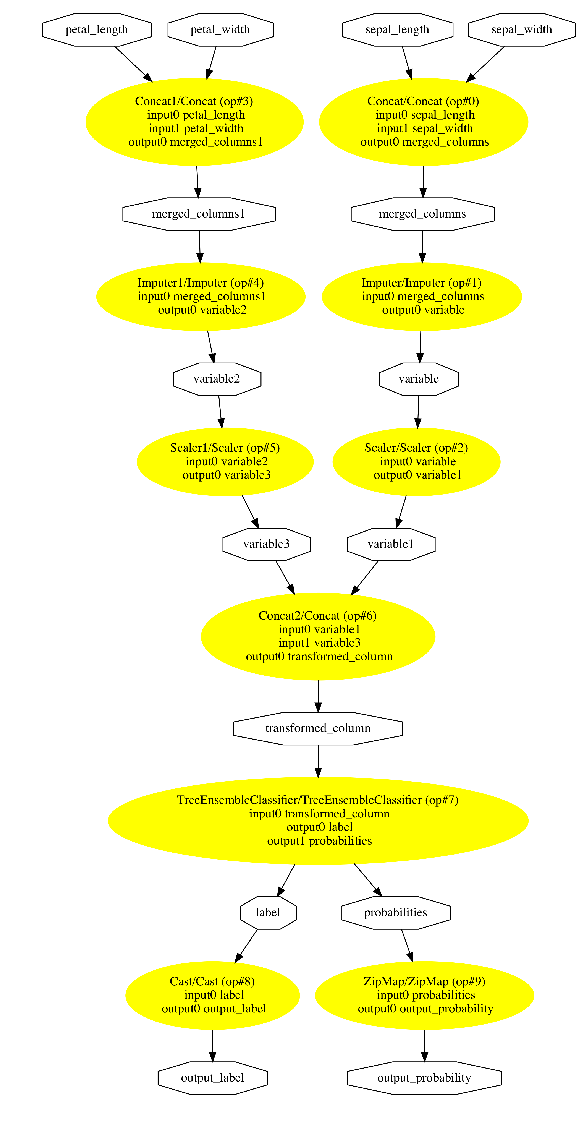

In [10]:
pydot_graph = GetPydotGraph(model_onnx.graph,
                            name=model_onnx.graph.name,
                            rankdir="TB",
                            node_producer=GetOpNodeProducer("docstring",
                                                            color="yellow",
                                                            fillcolor="yellow",
                                                            style="filled"))
pydot_graph.write_dot("iris_pipeline.dot")

os.system('dot -O -Gdpi=300 -Tpng iris_pipeline.dot')

image = plt.imread("iris_pipeline.dot.png")
fig, ax = plt.subplots(figsize=(40, 20))
ax.imshow(image)
ax.axis('off')